In [59]:
# imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import os
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF

In [60]:
# define encoder

class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.fc_mean = nn.Linear(64 * (input_shape[1] // 4) * (input_shape[2] // 4), latent_dim)
        self.fc_log_var = nn.Linear(64 * (input_shape[1] // 4) * (input_shape[2] // 4), latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        return z_mean, z_log_var

In [61]:
# define decoder

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super(Decoder, self).__init__()
        self.output_shape = output_shape
        self.fc = nn.Linear(latent_dim, 64 * (output_shape[1] // 4) * (output_shape[2] // 4))
        self.conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=output_shape[0], kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(64, (self.output_shape[1] // 4), (self.output_shape[2] // 4))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return torch.sigmoid(x)

In [62]:
# define VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self._sample(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed

    def _sample(self, z_mean, z_log_var):
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [63]:
# loss function

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta*kl_loss

In [64]:
# ensure cuda available

print(torch.cuda.is_available())

True


In [65]:
# prepare dataset

class RGBIRDataset(Dataset):
    def __init__(self, rgb_ir_folder, transform=None):
        self.rgb_ir_folder = rgb_ir_folder
        self.rgb_ir_filenames = os.listdir(rgb_ir_folder)
        self.transform = transform

    def __len__(self):
        return len(self.rgb_ir_filenames)

    def __getitem__(self, idx):
        rgb_ir_filename = self.rgb_ir_filenames[idx]
        rgb_ir_path = os.path.join(self.rgb_ir_folder, rgb_ir_filename)
        rgb_ir_image = Image.open(rgb_ir_path).convert('RGB')  # Load RGB-IR image
        rgb_ir_image = transforms.ToTensor()(np.asarray(rgb_ir_image))
        # Split RGB and IR channels
        rgb_image, ir_image = torch.split(rgb_ir_image, 1280, 2)
        #rgb_image, ir_image = torch.split(tensor=rgb_ir_image, split_size_or_sections=[3,1024,1280])
        if self.transform:
            rgb_image = self.transform(rgb_image)
            ir_image = self.transform(ir_image)
        return rgb_image, ir_image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.ToTensor(),
])

In [66]:
train_dataset = RGBIRDataset(rgb_ir_folder='data/LLVIP/visible-infrared/train', transform=transform)
test_dataset = RGBIRDataset(rgb_ir_folder='data/LLVIP/visible-infrared/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [67]:
# train model
def vae_train(vae, epochs=20, beta=1.0):
    losses=[]
    optimizer = optim.NAdam(vae.parameters())
    vae.train()
    for epoch in range(epochs):
        for batch_idx, (rgb_imgs, ir_imgs) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = rgb_imgs[0]
            true_ir = ir_imgs[0]
            pred_ir = vae(inputs)
            loss = vae_loss(pred_ir, true_ir, *vae.encoder(inputs), beta=beta)
            loss.backward()
            optimizer.step()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
    print('Done Training.')
    return vae, losses

In [68]:
# create model

input_shape = (3,256,256)
latent_dim = 64
encoder = Encoder(input_shape, latent_dim)
decoder = Decoder(latent_dim, input_shape)
vae = VAE(encoder, decoder)

In [69]:
vae_b1, loss_b1 = vae_train(vae, beta=1)

Train Epoch: 1 [0/12025 (0%)]	Loss: 17386.660156
Train Epoch: 1 [3/12025 (0%)]	Loss: 52609.933594
Train Epoch: 1 [6/12025 (1%)]	Loss: 15502.438477
Train Epoch: 1 [9/12025 (1%)]	Loss: 28657.246094
Train Epoch: 1 [12/12025 (1%)]	Loss: 62606.351562
Train Epoch: 1 [15/12025 (1%)]	Loss: 14719.076172
Train Epoch: 1 [18/12025 (2%)]	Loss: 10456.370117
Train Epoch: 1 [21/12025 (2%)]	Loss: 10366.083008
Train Epoch: 1 [24/12025 (2%)]	Loss: 24119.714844
Train Epoch: 1 [27/12025 (2%)]	Loss: 15564.406250
Train Epoch: 1 [30/12025 (3%)]	Loss: 12752.639648
Train Epoch: 1 [33/12025 (3%)]	Loss: 19601.539062
Train Epoch: 1 [36/12025 (3%)]	Loss: 9334.524414
Train Epoch: 1 [39/12025 (3%)]	Loss: 7866.230469
Train Epoch: 1 [42/12025 (4%)]	Loss: 9950.691406
Train Epoch: 1 [45/12025 (4%)]	Loss: 21879.248047
Train Epoch: 1 [48/12025 (4%)]	Loss: 9563.823242
Train Epoch: 1 [51/12025 (5%)]	Loss: 15528.745117
Train Epoch: 1 [54/12025 (5%)]	Loss: 13545.824219
Train Epoch: 1 [57/12025 (5%)]	Loss: 10983.525391
Train Ep

KeyboardInterrupt: 

In [70]:
vae_b1

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_mean): Linear(in_features=262144, out_features=64, bias=True)
    (fc_log_var): Linear(in_features=262144, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=262144, bias=True)
    (conv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

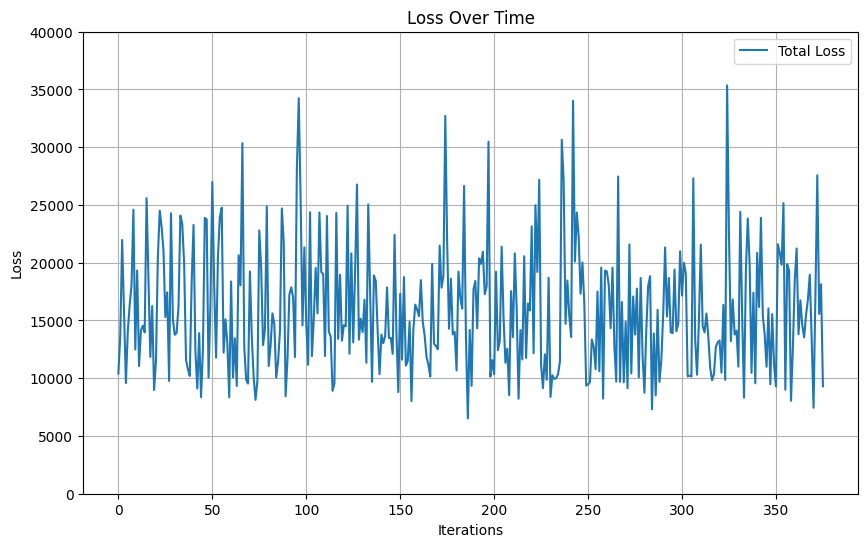

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(loss_b1, label='Total Loss')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim([0,40000])
plt.title('Loss Over Time')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
for batch_idx, (rgb_imgs, ir_imgs) in enumerate(train_loader):
    input_test = rgb_imgs[0]
    true_ir_test = ir_imgs[0]
    pred_ir_test = vae(input_test)
    break

In [73]:
vae_b1.decoder(torch.rand(64))

tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.

In [ ]:
pred_ir_test

tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.

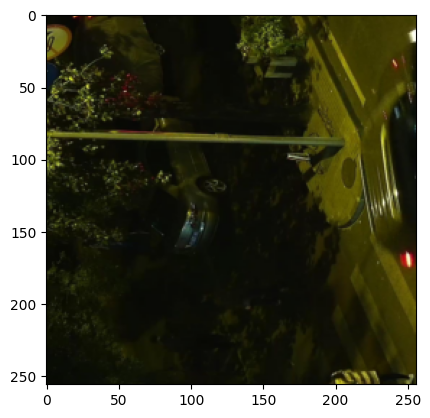

In [ ]:
a = input_test.detach().numpy() * 255
a = a.astype(np.uint8)
plt.imshow(a.T)
plt.imsave("data/coco-ir-vae/results/true_rgb.png",a.T)

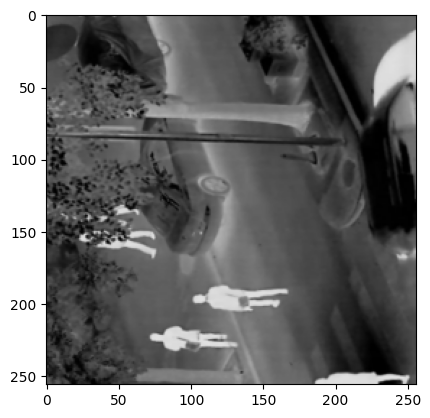

In [ ]:
b = true_ir_test.detach().numpy() * 255
b = b.astype(np.uint8)
plt.imshow(b.T)
plt.imsave("data/coco-ir-vae/results/true_ir.png",b.T)

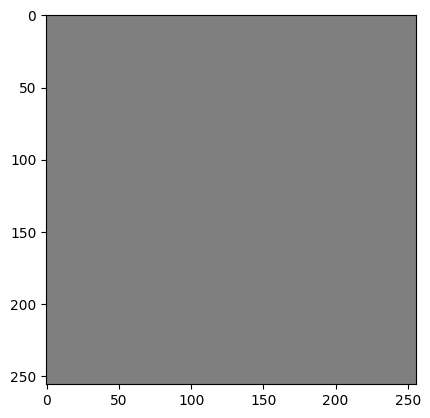

In [75]:
c = pred_ir_test.detach().numpy() * 255
c = c.astype(np.uint8)
plt.imshow(c.T)
plt.imsave("data/coco-ir-vae/results/pred_ir.png",c.T)